# Stock Price prediction with ARIMA model

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
#from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf

#from talib import abstract
#import talib as ta

#from backtesting import Strategy
#from backtesting.lib import crossover, SignalStrategy, TrailingStrategy
#from backtesting import Backtest

## Getting data and clean it up

In [2]:
Stock = 'SPY'
data = yf.download(Stock, period="5y")

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-02-16,188.770004,189.809998,187.630005,189.779999,172.308426,120250700
2016-02-17,191.160004,193.320007,191.009995,192.880005,175.123047,136009500
2016-02-18,193.199997,193.270004,191.720001,192.089996,174.405762,102343000
2016-02-19,191.169998,192.179993,190.449997,192.000000,174.324066,114793000
2016-02-22,193.869995,194.949997,193.789993,194.779999,176.848099,103640300


In [3]:
data = data.asfreq('D')

In [4]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-02-16,188.770004,189.809998,187.630005,189.779999,172.308426,120250700.0
2016-02-17,191.160004,193.320007,191.009995,192.880005,175.123047,136009500.0
2016-02-18,193.199997,193.270004,191.720001,192.089996,174.405762,102343000.0
2016-02-19,191.169998,192.179993,190.449997,192.000000,174.324066,114793000.0
2016-02-20,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-21,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-22,193.869995,194.949997,193.789993,194.779999,176.848099,103640300.0
2016-02-23,194.000000,194.320007,192.179993,192.320007,174.614578,111455300.0
2016-02-24,190.630005,193.529999,189.320007,193.199997,175.413559,150812200.0


In [5]:
data = data.ffill()

In [6]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-02-16,188.770004,189.809998,187.630005,189.779999,172.308426,120250700.0
2016-02-17,191.160004,193.320007,191.009995,192.880005,175.123047,136009500.0
2016-02-18,193.199997,193.270004,191.720001,192.089996,174.405762,102343000.0
2016-02-19,191.169998,192.179993,190.449997,192.000000,174.324066,114793000.0
2016-02-20,191.169998,192.179993,190.449997,192.000000,174.324066,114793000.0
2016-02-21,191.169998,192.179993,190.449997,192.000000,174.324066,114793000.0
2016-02-22,193.869995,194.949997,193.789993,194.779999,176.848099,103640300.0
2016-02-23,194.000000,194.320007,192.179993,192.320007,174.614578,111455300.0
2016-02-24,190.630005,193.529999,189.320007,193.199997,175.413559,150812200.0


In [7]:
data.index

DatetimeIndex(['2016-02-16', '2016-02-17', '2016-02-18', '2016-02-19',
               '2016-02-20', '2016-02-21', '2016-02-22', '2016-02-23',
               '2016-02-24', '2016-02-25',
               ...
               '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06',
               '2021-02-07', '2021-02-08', '2021-02-09', '2021-02-10',
               '2021-02-11', '2021-02-12'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

## Automate the augmented Dickey-Fuller Test
Writing a function that performs the augmented Dickey-Fuller Test.

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

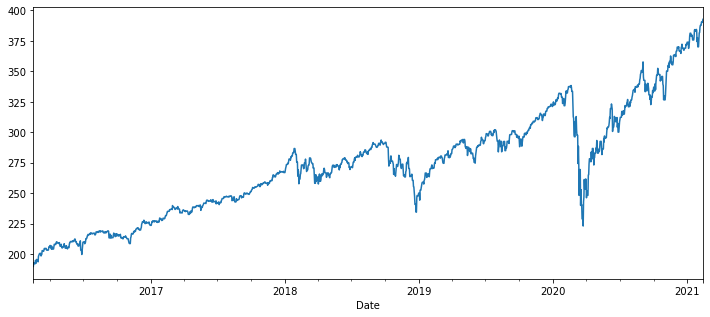

In [9]:
data['Close'].plot(figsize=(12,5));

In [10]:
adf_test(data['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -0.391104
p-value                    0.911573
# lags used               23.000000
# observations          1800.000000
critical value (1%)       -3.433988
critical value (5%)       -2.863147
critical value (10%)      -2.567626
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


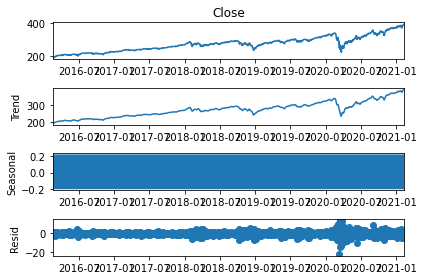

In [11]:
result = seasonal_decompose(data['Close'], model='additive')  # model='add' also works
result.plot();

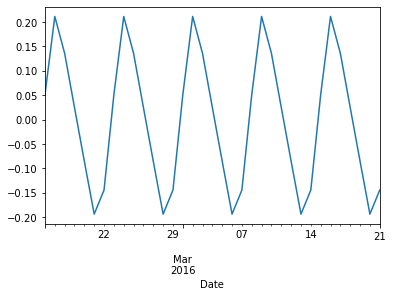

In [12]:
result.seasonal[:7*5].plot();
# There is 7-days seasonality, but it's just subtle. We don't have to use SARIMA model.

In [13]:
auto_arima(data['Close'], start_p=0, start_q=0, max_p=0, max_q=3, seasonal=False, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8820.982, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8784.101, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8822.038, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8764.620, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8761.805, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=8762.933, Time=0.10 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 0.815 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1824
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -4375.902
Date:                Mon, 15 Feb 2021   AIC                           8761.805
Time:                        21:48:41   BIC                           8789.346
Sample:                             0   HQIC                          8771.965
                               - 1824                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1110      0.068      1.625      0.104      -0.023       0.245
ma.L1         -0.1552      0.010    -16.287      0.000      -0.174      -0.137
ma.L2          0.1058      0.010     10.528      0.000       0.086       0.125
ma.L3          0.0531      0.008      6.315      0.000       0.037       0.070
sigma2         7.1196      0.070    101.434      0.000       6.982       7.257
===================================================================================
Ljung-Box (Q):                      212.56   Jarque-Bera (JB):             55241.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.49   Skew:                            -1.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets

In [14]:
len(data)

1824

In [15]:
1824-7*26

1642

In [16]:
# Set one year for testing
train = data.iloc[:1642]
test = data.iloc[1642:]

### Fit an ARIMA Model

In [17]:
model = ARIMA(train['Close'],order=(0,1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1641
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3908.061
Method:                       css-mle   S.D. of innovations              2.618
Date:                Mon, 15 Feb 2021   AIC                           7824.121
Time:                        21:48:41   BIC                           7845.733
Sample:                    02-17-2016   HQIC                          7832.136
                         - 08-14-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0895      0.060      1.492      0.136      -0.028       0.207
ma.L1.D.Close    -0.1719      0.025     -6.870      0.000      -0.221      -0.123
ma.L2.D.Close     0.0999      0.025      4.072      0.000       0.052       0.148
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.8600           -3.0441j            3.1633           -0.2062
MA.2            0.8600           +3.0441j            3.1633            0.2062
-----------------------------------------------------------------------------
"""

In [18]:
# Obtain predicted values
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(0,1,2) Predictions')

In [19]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Close'][i]}")

predicted=337.0298403, expected=336.8399963378906
predicted=337.0758406, expected=336.8399963378906
predicted=337.1653098, expected=337.9100036621094
predicted=337.2547791, expected=338.6400146484375
predicted=337.3442483, expected=337.2300109863281
predicted=337.4337175, expected=338.2799987792969
predicted=337.5231868, expected=339.4800109863281
predicted=337.612656 , expected=339.4800109863281
predicted=337.7021252, expected=339.4800109863281
predicted=337.7915944, expected=342.9200134277344
predicted=337.8810637, expected=344.1199951171875
predicted=337.9705329, expected=347.57000732421875
predicted=338.0600021, expected=348.3299865722656
predicted=338.1494714, expected=350.5799865722656
predicted=338.2389406, expected=350.5799865722656
predicted=338.3284098, expected=350.5799865722656
predicted=338.4178791, expected=349.30999755859375
predicted=338.5073483, expected=352.6000061035156
predicted=338.5968175, expected=357.70001220703125
predicted=338.6862867, expected=345.39001464843

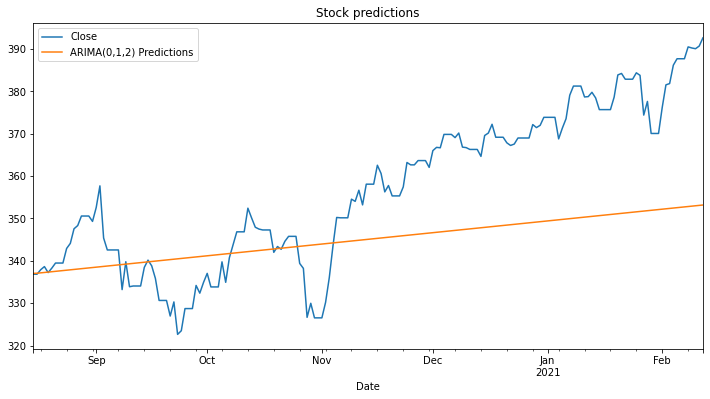

In [20]:
# Plot predictions against known values
title = 'Stock predictions'

ax = test['Close'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

### Evaluate the Model

In [21]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Close'], predictions)
print(f'ARIMA(0,1,1) MSE Error: {error:11.10}')  

ARIMA(0,1,1) MSE Error: 332.9568763


In [22]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Close'], predictions)
print(f'ARIMA(0,1,2) RMSE Error: {error:11.10}')

ARIMA(0,1,2) RMSE Error: 18.24710597


### Retrain the model on the full data, and forecast the future

In [23]:
model = ARIMA(data['Close'], order=(0,1,2))
results = model.fit()
fcast = results.predict(len(data),len(data)+7*26,dynamic=False,typ='levels').rename('ARIMA(0,1,2) Forecast')

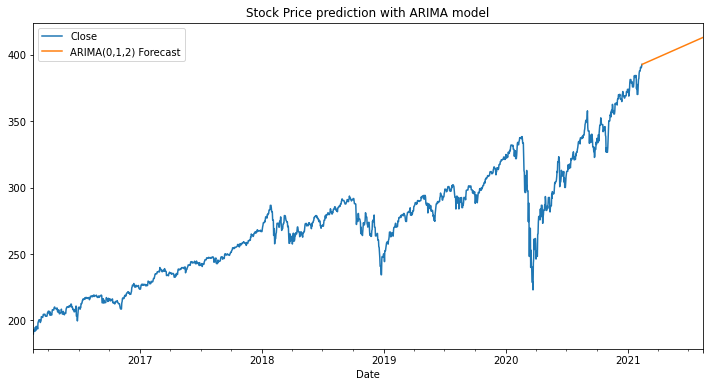

In [24]:
# Plot predictions against known values
title = 'Stock Price prediction with ARIMA model'

ax = data['Close'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)